Copyright (c) 2019 Gopal Krishna. Released under the MIT License

In [ ]:
pip install spectral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

In [ ]:
## GLOBAL VARIABLES
dataset = 'IP'
test_ratio = 0.7
windowSize = 25

In [ ]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'data')
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
        
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

In [ ]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [ ]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [ ]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [ ]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [ ]:
X, y = loadData(dataset)

X.shape, y.shape

((145, 145, 200), (145, 145))

In [ ]:
K = X.shape[2]

In [ ]:
K = 30 if dataset == 'IP' else 15
X,pca = applyPCA(X,numComponents=K)

X.shape

(145, 145, 30)

In [ ]:

X, y = createImageCubes(X, y, windowSize=windowSize,removeZeroLabels=False)

X.shape, y.shape

((21025, 25, 25, 30), (21025,))

In [ ]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((6307, 25, 25, 30), (14718, 25, 25, 30), (6307,), (14718,))

In [ ]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(6307, 25, 25, 30, 1)

In [ ]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(6307, 17)

In [ ]:
S = windowSize
L = K
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 17

In [ ]:
## input layer
input_layer = Input((S, S, L, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
print(conv_layer3.shape)
conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

(None, 19, 19, 18, 32)


In [ ]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25, 25, 30, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 23, 23, 24, 8)     512       
                                                                 
 conv3d_1 (Conv3D)           (None, 21, 21, 20, 16)    5776      
                                                                 
 conv3d_2 (Conv3D)           (None, 19, 19, 18, 32)    13856     
                                                                 
 reshape (Reshape)           (None, 19, 19, 576)       0         
                                                                 
 conv2d (Conv2D)             (None, 17, 17, 64)        331840    
                                                                 
 flatten (Flatten)           (None, 18496)             0     

In [ ]:
# compiling the model
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:
# checkpoint
filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, callbacks=callbacks_list)

Epoch 1/100
25/25 [==============================] - ETA: 0s - loss: 2.1686 - accuracy: 0.4714

25/25 [==============================] - 20s 283ms/step - loss: 2.1686 - accuracy: 0.4714
Epoch 2/100
25/25 [==============================] - ETA: 0s - loss: 1.7668 - accuracy: 0.5124

25/25 [==============================] - 5s 217ms/step - loss: 1.7668 - accuracy: 0.5124
Epoch 3/100
25/25 [==============================] - ETA: 0s - loss: 1.5192 - accuracy: 0.5440

25/25 [==============================] - 5s 216ms/step - loss: 1.5192 - accuracy: 0.5440
Epoch 4/100
25/25 [==============================] - ETA: 0s - loss: 1.2076 - accuracy: 0.6184

25/25 [==============================] - 5s 215ms/step - loss: 1.2076 - accuracy: 0.6184
Epoch 5/100
25/25 [==============================] - ETA: 0s - loss: 0.9187 - accuracy: 0.6937

25/25 [==============================] - 6s 227ms/step - loss: 0.9187 - accuracy: 0.6937
Epoch 6/100
25/25 [==============================] - ETA: 0s - loss: 0.6689 - accuracy: 0.7677

25/25 [==============================] - 6s 221ms/step - loss: 0.6689 - accuracy: 0.7677
Epoch 7/100
25/25 [==============================] - ETA: 0s - loss: 0.4912 - accuracy: 0.8373

25/25 [==============================] - 5s 215ms/step - loss: 0.4912 - accuracy: 0.8373
Epoch 8/100
25/25 [==============================] - ETA: 0s - loss: 0.4071 - accuracy: 0.8663

25/25 [==============================] - 5s 216ms/step - loss: 0.4071 - accuracy: 0.8663
Epoch 9/100
25/25 [==============================] - ETA: 0s - loss: 0.3511 - accuracy: 0.8831

25/25 [==============================] - 5s 212ms/step - loss: 0.3511 - accuracy: 0.8831
Epoch 10/100
25/25 [==============================] - ETA: 0s - loss: 0.2855 - accuracy: 0.9061

25/25 [==============================] - 5s 214ms/step - loss: 0.2855 - accuracy: 0.9061
Epoch 11/100
25/25 [==============================] - ETA: 0s - loss: 0.2315 - accuracy: 0.9228

25/25 [==============================] - 5s 214ms/step - loss: 0.2315 - accuracy: 0.9228
Epoch 12/100
25/25 [==============================] - ETA: 0s - loss: 0.2021 - accuracy: 0.9304

25/25 [==============================] - 5s 212ms/step - loss: 0.2021 - accuracy: 0.9304
Epoch 13/100
25/25 [==============================] - ETA: 0s - loss: 0.1875 - accuracy: 0.9363

25/25 [==============================] - 5s 214ms/step - loss: 0.1875 - accuracy: 0.9363
Epoch 14/100
25/25 [==============================] - ETA: 0s - loss: 0.1683 - accuracy: 0.9412

25/25 [==============================] - 5s 212ms/step - loss: 0.1683 - accuracy: 0.9412
Epoch 15/100
25/25 [==============================] - ETA: 0s - loss: 0.1791 - accuracy: 0.9396

25/25 [==============================] - 5s 213ms/step - loss: 0.1791 - accuracy: 0.9396
Epoch 16/100
25/25 [==============================] - ETA: 0s - loss: 0.1431 - accuracy: 0.9504

25/25 [==============================] - 5s 212ms/step - loss: 0.1431 - accuracy: 0.9504
Epoch 17/100
25/25 [==============================] - ETA: 0s - loss: 0.1259 - accuracy: 0.9566

25/25 [==============================] - 5s 212ms/step - loss: 0.1259 - accuracy: 0.9566
Epoch 18/100
25/25 [==============================] - ETA: 0s - loss: 0.1190 - accuracy: 0.9585

25/25 [==============================] - 5s 214ms/step - loss: 0.1190 - accuracy: 0.9585
Epoch 19/100
25/25 [==============================] - ETA: 0s - loss: 0.1021 - accuracy: 0.9664

25/25 [==============================] - 5s 212ms/step - loss: 0.1021 - accuracy: 0.9664
Epoch 20/100
25/25 [==============================] - ETA: 0s - loss: 0.0967 - accuracy: 0.9683

25/25 [==============================] - 5s 215ms/step - loss: 0.0967 - accuracy: 0.9683
Epoch 21/100
25/25 [==============================] - ETA: 0s - loss: 0.1003 - accuracy: 0.9673

25/25 [==============================] - 5s 215ms/step - loss: 0.1003 - accuracy: 0.9673
Epoch 22/100
25/25 [==============================] - ETA: 0s - loss: 0.0863 - accuracy: 0.9677

25/25 [==============================] - 5s 213ms/step - loss: 0.0863 - accuracy: 0.9677
Epoch 23/100
25/25 [==============================] - ETA: 0s - loss: 0.0838 - accuracy: 0.9691

25/25 [==============================] - 5s 219ms/step - loss: 0.0838 - accuracy: 0.9691
Epoch 24/100
25/25 [==============================] - ETA: 0s - loss: 0.0810 - accuracy: 0.9735

25/25 [==============================] - 5s 212ms/step - loss: 0.0810 - accuracy: 0.9735
Epoch 25/100
25/25 [==============================] - ETA: 0s - loss: 0.0637 - accuracy: 0.9770

25/25 [==============================] - 5s 214ms/step - loss: 0.0637 - accuracy: 0.9770
Epoch 26/100
25/25 [==============================] - ETA: 0s - loss: 0.0666 - accuracy: 0.9781

25/25 [==============================] - 5s 213ms/step - loss: 0.0666 - accuracy: 0.9781
Epoch 27/100
25/25 [==============================] - ETA: 0s - loss: 0.0832 - accuracy: 0.9745

25/25 [==============================] - 5s 212ms/step - loss: 0.0832 - accuracy: 0.9745
Epoch 28/100
25/25 [==============================] - ETA: 0s - loss: 0.0651 - accuracy: 0.9786

25/25 [==============================] - 5s 214ms/step - loss: 0.0651 - accuracy: 0.9786
Epoch 29/100
25/25 [==============================] - ETA: 0s - loss: 0.0570 - accuracy: 0.9814

25/25 [==============================] - 5s 212ms/step - loss: 0.0570 - accuracy: 0.9814
Epoch 30/100
25/25 [==============================] - ETA: 0s - loss: 0.0488 - accuracy: 0.9830

25/25 [==============================] - 5s 215ms/step - loss: 0.0488 - accuracy: 0.9830
Epoch 31/100
25/25 [==============================] - ETA: 0s - loss: 0.0546 - accuracy: 0.9816

25/25 [==============================] - 5s 212ms/step - loss: 0.0546 - accuracy: 0.9816
Epoch 32/100
25/25 [==============================] - ETA: 0s - loss: 0.0549 - accuracy: 0.9818

25/25 [==============================] - 5s 212ms/step - loss: 0.0549 - accuracy: 0.9818
Epoch 33/100
25/25 [==============================] - ETA: 0s - loss: 0.0532 - accuracy: 0.9819

25/25 [==============================] - 5s 214ms/step - loss: 0.0532 - accuracy: 0.9819
Epoch 34/100
25/25 [==============================] - ETA: 0s - loss: 0.0514 - accuracy: 0.9838

25/25 [==============================] - 5s 211ms/step - loss: 0.0514 - accuracy: 0.9838
Epoch 35/100
25/25 [==============================] - ETA: 0s - loss: 0.0373 - accuracy: 0.9895

25/25 [==============================] - 5s 214ms/step - loss: 0.0373 - accuracy: 0.9895
Epoch 36/100
25/25 [==============================] - ETA: 0s - loss: 0.0318 - accuracy: 0.9884

25/25 [==============================] - 5s 213ms/step - loss: 0.0318 - accuracy: 0.9884
Epoch 37/100
25/25 [==============================] - ETA: 0s - loss: 0.0374 - accuracy: 0.9878

25/25 [==============================] - 5s 212ms/step - loss: 0.0374 - accuracy: 0.9878
Epoch 38/100
25/25 [==============================] - ETA: 0s - loss: 0.0300 - accuracy: 0.9903

25/25 [==============================] - 5s 214ms/step - loss: 0.0300 - accuracy: 0.9903
Epoch 39/100
25/25 [==============================] - ETA: 0s - loss: 0.0321 - accuracy: 0.9879

25/25 [==============================] - 5s 213ms/step - loss: 0.0321 - accuracy: 0.9879
Epoch 40/100
25/25 [==============================] - ETA: 0s - loss: 0.0350 - accuracy: 0.9891

25/25 [==============================] - 5s 213ms/step - loss: 0.0350 - accuracy: 0.9891
Epoch 41/100
25/25 [==============================] - ETA: 0s - loss: 0.0422 - accuracy: 0.9879

25/25 [==============================] - 5s 213ms/step - loss: 0.0422 - accuracy: 0.9879
Epoch 42/100
25/25 [==============================] - ETA: 0s - loss: 0.0466 - accuracy: 0.9853

25/25 [==============================] - 5s 212ms/step - loss: 0.0466 - accuracy: 0.9853
Epoch 43/100
25/25 [==============================] - ETA: 0s - loss: 0.0325 - accuracy: 0.9914

25/25 [==============================] - 5s 215ms/step - loss: 0.0325 - accuracy: 0.9914
Epoch 44/100
25/25 [==============================] - ETA: 0s - loss: 0.0326 - accuracy: 0.9895

25/25 [==============================] - 5s 212ms/step - loss: 0.0326 - accuracy: 0.9895
Epoch 45/100
25/25 [==============================] - ETA: 0s - loss: 0.0235 - accuracy: 0.9919

25/25 [==============================] - 5s 212ms/step - loss: 0.0235 - accuracy: 0.9919
Epoch 46/100
25/25 [==============================] - ETA: 0s - loss: 0.0336 - accuracy: 0.9889

25/25 [==============================] - 5s 213ms/step - loss: 0.0336 - accuracy: 0.9889
Epoch 47/100
25/25 [==============================] - ETA: 0s - loss: 0.0261 - accuracy: 0.9916

25/25 [==============================] - 5s 212ms/step - loss: 0.0261 - accuracy: 0.9916
Epoch 48/100
25/25 [==============================] - ETA: 0s - loss: 0.0305 - accuracy: 0.9906

25/25 [==============================] - 5s 215ms/step - loss: 0.0305 - accuracy: 0.9906
Epoch 49/100
25/25 [==============================] - ETA: 0s - loss: 0.0248 - accuracy: 0.9906

25/25 [==============================] - 5s 212ms/step - loss: 0.0248 - accuracy: 0.9906
Epoch 50/100
25/25 [==============================] - ETA: 0s - loss: 0.0246 - accuracy: 0.9930

25/25 [==============================] - 5s 213ms/step - loss: 0.0246 - accuracy: 0.9930
Epoch 51/100
25/25 [==============================] - ETA: 0s - loss: 0.0213 - accuracy: 0.9925

25/25 [==============================] - 5s 213ms/step - loss: 0.0213 - accuracy: 0.9925
Epoch 52/100
25/25 [==============================] - ETA: 0s - loss: 0.0239 - accuracy: 0.9922

25/25 [==============================] - 5s 212ms/step - loss: 0.0239 - accuracy: 0.9922
Epoch 53/100
25/25 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.9932

25/25 [==============================] - 5s 216ms/step - loss: 0.0244 - accuracy: 0.9932
Epoch 54/100
25/25 [==============================] - ETA: 0s - loss: 0.0209 - accuracy: 0.9927

25/25 [==============================] - 5s 212ms/step - loss: 0.0209 - accuracy: 0.9927
Epoch 55/100
25/25 [==============================] - ETA: 0s - loss: 0.0220 - accuracy: 0.9933

25/25 [==============================] - 5s 212ms/step - loss: 0.0220 - accuracy: 0.9933
Epoch 56/100
25/25 [==============================] - ETA: 0s - loss: 0.0164 - accuracy: 0.9948

25/25 [==============================] - 5s 212ms/step - loss: 0.0164 - accuracy: 0.9948
Epoch 57/100
25/25 [==============================] - ETA: 0s - loss: 0.0158 - accuracy: 0.9949

25/25 [==============================] - 5s 213ms/step - loss: 0.0158 - accuracy: 0.9949
Epoch 58/100
25/25 [==============================] - ETA: 0s - loss: 0.0215 - accuracy: 0.9937

25/25 [==============================] - 5s 215ms/step - loss: 0.0215 - accuracy: 0.9937
Epoch 59/100
25/25 [==============================] - ETA: 0s - loss: 0.0204 - accuracy: 0.9941

25/25 [==============================] - 5s 212ms/step - loss: 0.0204 - accuracy: 0.9941
Epoch 60/100
25/25 [==============================] - ETA: 0s - loss: 0.0172 - accuracy: 0.9957

25/25 [==============================] - 5s 213ms/step - loss: 0.0172 - accuracy: 0.9957
Epoch 61/100
25/25 [==============================] - ETA: 0s - loss: 0.0165 - accuracy: 0.9952

25/25 [==============================] - 5s 213ms/step - loss: 0.0165 - accuracy: 0.9952
Epoch 62/100
25/25 [==============================] - ETA: 0s - loss: 0.0177 - accuracy: 0.9946

25/25 [==============================] - 5s 212ms/step - loss: 0.0177 - accuracy: 0.9946
Epoch 63/100
25/25 [==============================] - ETA: 0s - loss: 0.0166 - accuracy: 0.9951

25/25 [==============================] - 5s 214ms/step - loss: 0.0166 - accuracy: 0.9951
Epoch 64/100
25/25 [==============================] - ETA: 0s - loss: 0.0238 - accuracy: 0.9935

25/25 [==============================] - 5s 212ms/step - loss: 0.0238 - accuracy: 0.9935
Epoch 65/100
25/25 [==============================] - ETA: 0s - loss: 0.0156 - accuracy: 0.9957

25/25 [==============================] - 5s 212ms/step - loss: 0.0156 - accuracy: 0.9957
Epoch 66/100
25/25 [==============================] - ETA: 0s - loss: 0.0173 - accuracy: 0.9940

25/25 [==============================] - 5s 213ms/step - loss: 0.0173 - accuracy: 0.9940
Epoch 67/100
25/25 [==============================] - ETA: 0s - loss: 0.0167 - accuracy: 0.9956

25/25 [==============================] - 5s 211ms/step - loss: 0.0167 - accuracy: 0.9956
Epoch 68/100
25/25 [==============================] - ETA: 0s - loss: 0.0169 - accuracy: 0.9956

25/25 [==============================] - 5s 214ms/step - loss: 0.0169 - accuracy: 0.9956
Epoch 69/100
25/25 [==============================] - ETA: 0s - loss: 0.0136 - accuracy: 0.9956

25/25 [==============================] - 5s 212ms/step - loss: 0.0136 - accuracy: 0.9956
Epoch 70/100
25/25 [==============================] - ETA: 0s - loss: 0.0096 - accuracy: 0.9968

25/25 [==============================] - 5s 213ms/step - loss: 0.0096 - accuracy: 0.9968
Epoch 71/100
25/25 [==============================] - ETA: 0s - loss: 0.0175 - accuracy: 0.9957

25/25 [==============================] - 5s 213ms/step - loss: 0.0175 - accuracy: 0.9957
Epoch 72/100
25/25 [==============================] - ETA: 0s - loss: 0.0153 - accuracy: 0.9959

25/25 [==============================] - 5s 213ms/step - loss: 0.0153 - accuracy: 0.9959
Epoch 73/100
25/25 [==============================] - ETA: 0s - loss: 0.0219 - accuracy: 0.9954

25/25 [==============================] - 5s 213ms/step - loss: 0.0219 - accuracy: 0.9954
Epoch 74/100
25/25 [==============================] - ETA: 0s - loss: 0.0259 - accuracy: 0.9925

25/25 [==============================] - 5s 211ms/step - loss: 0.0259 - accuracy: 0.9925
Epoch 75/100
25/25 [==============================] - ETA: 0s - loss: 0.0193 - accuracy: 0.9952

25/25 [==============================] - 5s 213ms/step - loss: 0.0193 - accuracy: 0.9952
Epoch 76/100
25/25 [==============================] - ETA: 0s - loss: 0.0174 - accuracy: 0.9949

25/25 [==============================] - 5s 213ms/step - loss: 0.0174 - accuracy: 0.9949
Epoch 77/100
25/25 [==============================] - ETA: 0s - loss: 0.0182 - accuracy: 0.9946

25/25 [==============================] - 5s 211ms/step - loss: 0.0182 - accuracy: 0.9946
Epoch 78/100
25/25 [==============================] - ETA: 0s - loss: 0.0155 - accuracy: 0.9962

25/25 [==============================] - 5s 214ms/step - loss: 0.0155 - accuracy: 0.9962
Epoch 79/100
25/25 [==============================] - ETA: 0s - loss: 0.0234 - accuracy: 0.9940

25/25 [==============================] - 5s 211ms/step - loss: 0.0234 - accuracy: 0.9940
Epoch 80/100
25/25 [==============================] - ETA: 0s - loss: 0.0152 - accuracy: 0.9957

25/25 [==============================] - 5s 212ms/step - loss: 0.0152 - accuracy: 0.9957
Epoch 81/100
25/25 [==============================] - ETA: 0s - loss: 0.0171 - accuracy: 0.9948

25/25 [==============================] - 5s 213ms/step - loss: 0.0171 - accuracy: 0.9948
Epoch 82/100
25/25 [==============================] - ETA: 0s - loss: 0.0107 - accuracy: 0.9960

25/25 [==============================] - 5s 211ms/step - loss: 0.0107 - accuracy: 0.9960
Epoch 83/100
25/25 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 0.9960

25/25 [==============================] - 5s 213ms/step - loss: 0.0104 - accuracy: 0.9960
Epoch 84/100
25/25 [==============================] - ETA: 0s - loss: 0.0072 - accuracy: 0.9975

25/25 [==============================] - 5s 211ms/step - loss: 0.0072 - accuracy: 0.9975
Epoch 85/100
25/25 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 0.9965

25/25 [==============================] - 5s 212ms/step - loss: 0.0105 - accuracy: 0.9965
Epoch 86/100
25/25 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 0.9951

25/25 [==============================] - 5s 213ms/step - loss: 0.0147 - accuracy: 0.9951
Epoch 87/100
25/25 [==============================] - ETA: 0s - loss: 0.0133 - accuracy: 0.9948

25/25 [==============================] - 5s 212ms/step - loss: 0.0133 - accuracy: 0.9948
Epoch 88/100
25/25 [==============================] - ETA: 0s - loss: 0.0169 - accuracy: 0.9951

25/25 [==============================] - 5s 215ms/step - loss: 0.0169 - accuracy: 0.9951
Epoch 89/100
25/25 [==============================] - ETA: 0s - loss: 0.0143 - accuracy: 0.9952

25/25 [==============================] - 5s 212ms/step - loss: 0.0143 - accuracy: 0.9952
Epoch 90/100
25/25 [==============================] - ETA: 0s - loss: 0.0133 - accuracy: 0.9960

25/25 [==============================] - 5s 212ms/step - loss: 0.0133 - accuracy: 0.9960
Epoch 91/100
25/25 [==============================] - ETA: 0s - loss: 0.0138 - accuracy: 0.9964

25/25 [==============================] - 5s 213ms/step - loss: 0.0138 - accuracy: 0.9964
Epoch 92/100
25/25 [==============================] - ETA: 0s - loss: 0.0088 - accuracy: 0.9971

25/25 [==============================] - 5s 211ms/step - loss: 0.0088 - accuracy: 0.9971
Epoch 93/100
25/25 [==============================] - ETA: 0s - loss: 0.0134 - accuracy: 0.9968

25/25 [==============================] - 5s 214ms/step - loss: 0.0134 - accuracy: 0.9968
Epoch 94/100
25/25 [==============================] - ETA: 0s - loss: 0.0148 - accuracy: 0.9954

25/25 [==============================] - 5s 212ms/step - loss: 0.0148 - accuracy: 0.9954
Epoch 95/100
25/25 [==============================] - ETA: 0s - loss: 0.0191 - accuracy: 0.9948

25/25 [==============================] - 5s 211ms/step - loss: 0.0191 - accuracy: 0.9948
Epoch 96/100
25/25 [==============================] - ETA: 0s - loss: 0.0143 - accuracy: 0.9967

25/25 [==============================] - 5s 213ms/step - loss: 0.0143 - accuracy: 0.9967
Epoch 97/100
25/25 [==============================] - ETA: 0s - loss: 0.0129 - accuracy: 0.9956

25/25 [==============================] - 5s 211ms/step - loss: 0.0129 - accuracy: 0.9956
Epoch 98/100
25/25 [==============================] - ETA: 0s - loss: 0.0215 - accuracy: 0.9938

25/25 [==============================] - 5s 213ms/step - loss: 0.0215 - accuracy: 0.9938
Epoch 99/100
25/25 [==============================] - ETA: 0s - loss: 0.0151 - accuracy: 0.9956

25/25 [==============================] - 5s 211ms/step - loss: 0.0151 - accuracy: 0.9956
Epoch 100/100
25/25 [==============================] - ETA: 0s - loss: 0.0173 - accuracy: 0.9948

25/25 [==============================] - 5s 211ms/step - loss: 0.0173 - accuracy: 0.9948


In [ ]:
# load best weights
#model.load_weights("best-model.hdf5")
#model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:

X,y,Xtrain,ytrain=0,0,0,0

In [ ]:

Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(14718, 25, 25, 30, 1)

In [ ]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(14718, 17)

In [ ]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

460/460 [==============================] - 5s 10ms/step
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      7543
           1       0.81      0.81      0.81        32
           2       0.95      0.96      0.95      1000
           3       0.96      0.94      0.95       581
           4       0.97      0.96      0.97       166
           5       0.93      0.96      0.94       338
           6       0.97      0.92      0.95       511
           7       0.68      0.75      0.71        20
           8       0.98      0.98      0.98       335
           9       0.86      0.86      0.86        14
          10       0.94      0.97      0.95       680
          11       0.94      0.99      0.96      1719
          12       0.95      0.96      0.95       415
          13       0.97      0.99      0.98       143
          14       0.93      0.98      0.95       886
          15       0.98      0.96      0.97       270
          16       0.93  

In [ ]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [ ]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Unlabeled','Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [ ]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

460/460 [==============================] - 6s 12ms/step - loss: 0.2561 - accuracy: 0.9566


In [ ]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [ ]:
# load the original image
X, y = loadData(dataset)

In [ ]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [ ]:
X,pca = applyPCA(X, numComponents=numComponents)

In [ ]:
X = padWithZeros(X, PATCH_SIZE//2)

In [ ]:
print(X.shape)

(169, 169, 30)


In [ ]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        #if target == 0 :
        #    continue
        #else :
        image_patch=Patch(X,i,j)
        X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
        prediction = (model.predict(X_test_image))
        prediction = np.argmax(prediction, axis=1)
        outputs[i][j] = prediction

Se truncaron las últimas líneas 5000 del resultado de transmisión.
1/1 [==============================] - 0s 30ms/step


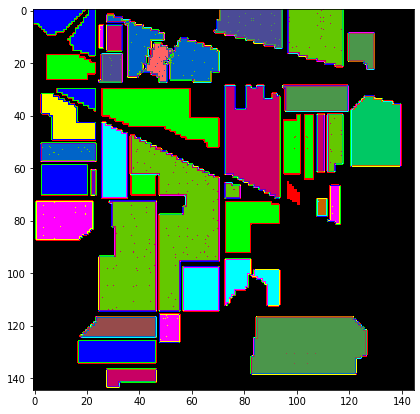

In [ ]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

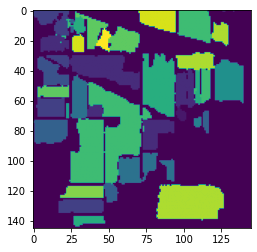

In [ ]:
gt_pred=outputs
plt.imshow(gt_pred)
labels = sio.loadmat("Indian_pines_ground_truth.mat")['indian_pines_gt']


In [ ]:
from keras.metrics import MeanIoU 
IOU_mean=MeanIoU(num_classes=17)
IOU_mean.update_state(gt_pred,labels)
print(IOU_mean.result().numpy())

0.90097433
